<ErrorbarContainer object of 3 artists>

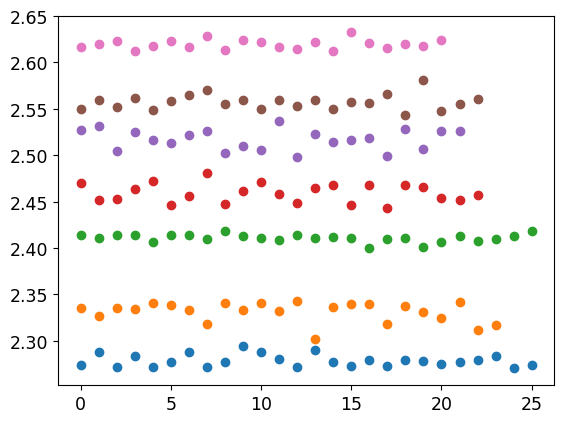

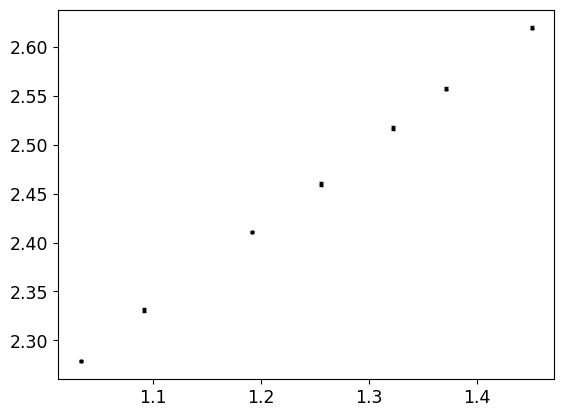

In [1]:
from os import listdir
from os.path import join
from numpy import *
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
matplotlib.rcParams.update({'font.size': 12.5})


# Load my modules.
import sys
with open("modules.txt") as file:
    for line in file:
        path = line.rstrip()
        sys.path.append(path)
from CommonUtilities import *


# Global settings
data_folder = "Block 2"
in_to_cm = 0.0254


# Uses Kinovea for motion tracking.
def read_Kinovea(path: str) -> tuple[float, float, float]:
    """
    Reads the csv output of Kinovea motion tracking.

    Params
    ------
    path: str
        Location of the data.
    
    Returns
    -------
    L: float
        Interpret file format "a_b_c" as a + b / c inches.
    T_avg: float
        Estimate for the pendulum period.
    dT: float
        Uncertainty in the pendulum period.
    """

    # Read using Pandas.
    data = pd.read_csv(path)
    t_i = data["Time (ms)"].to_numpy() / 1000
    x_i = data["Trajectory 1"].to_numpy()

    # Fit a cubic spline to correct for frame time.
    T_run, dgrid = amax(t_i) - amin(t_i), 1e-5
    t_grid = linspace(amin(t_i), amax(t_i), int(T_run / dgrid))
    x_grid = CubicSpline(t_i, x_i)(t_grid)
    I_peak = find_peaks(x_grid)[0][1:-1]

    # Average peak-to-peak time.
    t_peaks = t_grid[I_peak]
    T_I = diff(t_peaks)
    T_avg = average(T_I)
    I_keep = where(abs(T_I - T_avg) < 0.1 * T_avg)
    T_I = T_I[I_keep]

    # Calculate statistics.
    N = len(T_I)
    T_avg = average(T_I)
    dT = std(T_I, ddof=1) / sqrt(N)
    a, b, c = array(file[:-4].split("_"), dtype=float)
    L = (a + b / c) * in_to_cm

    # Plot to confirm correctness.
    plt.scatter(arange(N), T_I)
    return (L, T_avg, dT)


# Process each pendulum run.
data_files = []
Ls, T_avgs, T_stds = [], [], []
for file in listdir(data_folder):
    L, T_avg, dT = read_Kinovea(join(data_folder, file))
    Ls.append(L)
    T_avgs.append(T_avg)
    T_stds.append(dT)
Ls, T_avgs, T_stds = array(Ls), array(T_avgs), array(T_stds)
plt.figure()
plt.errorbar(Ls, T_avgs, yerr=T_stds, fmt='o', c="k", markersize=2, capsize=1.5, elinewidth=0.75)

In [2]:
T_stds / T_avgs

array([0.00056457, 0.00094234, 0.00034603, 0.00085791, 0.00094077,
       0.00067498, 0.00042829])

In [2]:
# Simplest model.
def model1(L: float, g: float) -> float:
    return 2 * pi * sqrt(L / g)
args1, covs1 = curve_fit(model1, xdata=Ls, ydata=T_avgs, sigma=T_stds,
                         p0 = [9.8])
stds1 = sqrt(diag(covs1))
print(args1)
print(stds1)

# Corrects for distance between measurement point and COM.
def model2(L: float, delta: float, g: float) -> float:
    return 2 * pi * sqrt((L + delta) / g)
args2, covs2 = curve_fit(model2, xdata=Ls, ydata=T_avgs, sigma=T_stds,
                         p0 = [0, 9.8])
stds2 = sqrt(diag(covs2))
print(args2)
print(stds2)

# Corrects for distance between measurement point and COM.
def model3(L: float, beta: float, delta: float, g: float) -> float:
    return 2 * pi * sqrt((beta ** 2 + (L + delta) ** 2) / (g * (L + delta)))
args3, covs3 = curve_fit(model3, xdata=Ls, ydata=T_avgs, sigma=T_stds,
                         p0 = [0, 0, 9.8])
stds3 = sqrt(diag(covs3))
print(args3)
print(stds3)

# Do the chi-squared analysis
chi2 = calc_chi2(model2, args2, Ls, T_avgs, T_stds)
p_chi2 = calc_chi2_prob(chi2, len(Ls) - len(args2))

[8.1470913]
[0.06657416]
[0.26225356 9.86701544]
[0.01146696 0.07557254]
[ 0.39475275 -0.03063279  8.80128767]
[0.0293697  0.07062461 0.28690192]


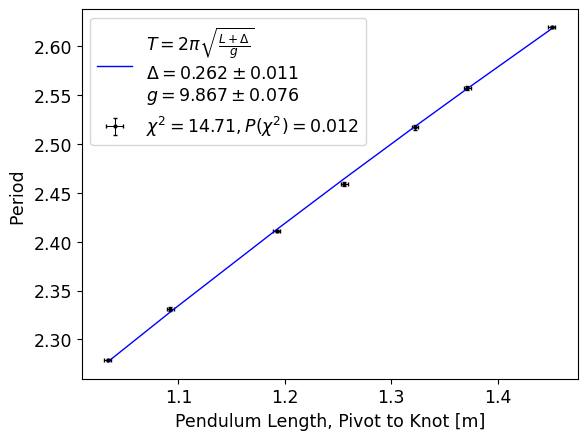

In [9]:
plt.errorbar(Ls, T_avgs, xerr=1/8 * in_to_cm, yerr=T_stds,
             fmt='o', c="k", markersize=2, capsize=1.5, elinewidth=0.75,
             label=rf"$\chi^2={chi2:.2f}, P(\chi^2)={p_chi2:.3f}$")
plt.plot(Ls, model2(Ls, *args2),
         c="b", lw=1,
         label=f"$T = 2\\pi \\sqrt{{\\frac{{L + \\Delta}}{{g}}}}$\n$\\Delta={args2[0]:.3}\\pm{stds2[0]:.3f}$\n$g={args2[1]:.4}\\pm{stds2[1]:.3f}$")
plt.legend()
plt.xlabel("Pendulum Length, Pivot to Knot [m]")
plt.ylabel("Period ")
plt.savefig("FinalPlot.png", dpi=300, bbox_inches="tight")